# 프로젝트: ResNet Ablation Study

## 0) 라이브러리 버전 확인하기

In [38]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


## 1) ResNet 기본 블록 구성하기


이제 실전으로 돌아와서 ResNet-34와 ResNet-50 네트워크를 직접 만든다고 생각해 봅시다. 우선 ResNet-34와 ResNet-50에서 사용되는 블록의 공통점을 찾고 차이점을 찾아봅시다.

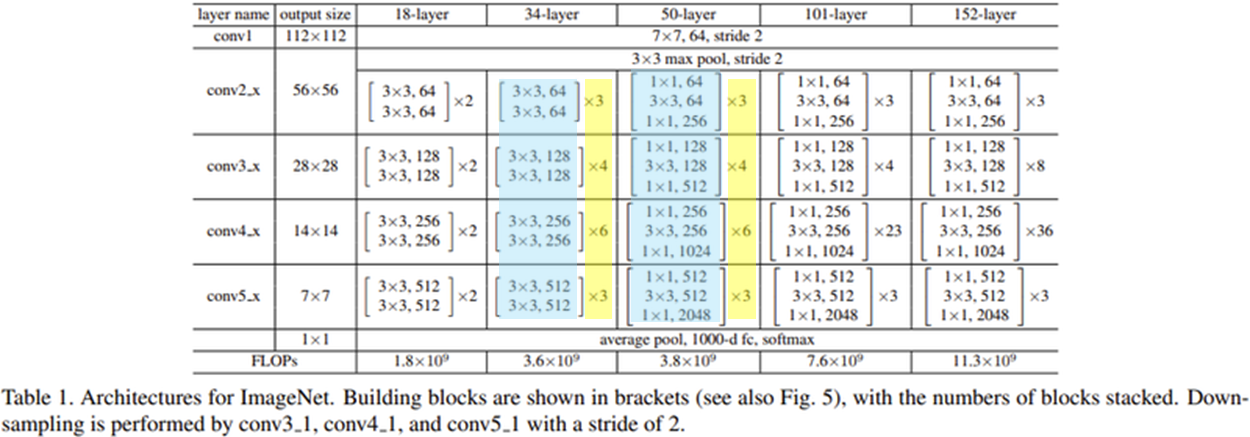

- 공통점(노란색 표시):
    - 각 n번째 Conv 블록의 구조 반복 횟수가 각각 3, 4, 6, 3으로 동일하다.
    
- 차이점(파란색 표시):
    - ResNet-34: 블록 당 (3 $\times$ 3) Conv Layer 2개로 구성
    - ResNet-50: 블록 당 (1 $\times$ 1), (3 $\times$ 3), (1 $\times$ 1) 총 3개 Conv Layer로 구성

### ResNet 블록 생성 함수

In [7]:
def build_resnet_block(x, channel=64, block_num=1, bottle_neck=False,
                       stride=1):
    
    # 입력 레이어 x의 identity 저장
    identity = x

    # Conv 레이어: Bottle_neck여부에 따라 3층 혹은 2층
    num_layer = 2 if bottle_neck else 1
    for cnn_num in range(num_layer + 1):
        
        # Conv
        x = keras.layers.Conv2D(
            # Bottle_neck의 경우 마지막층 채널 수 조정
            filters=channel if cnn_num != 2 else channel * 4,
            # Bottle_neck의 경우 처음과 마지막 커널 사이즈 1*1
            kernel_size= 1 if (bottle_neck and cnn_num in [0,2]) else 3,
            # 첫 레이어의 stride는 입력에 따라 조절 (Stage의 첫 레이어)
            strides=1 if cnn_num else stride,
            kernel_initializer='he_normal', padding='same',
            name=f'block{block_num}_conv{cnn_num}')(x)
        
        # Batch Norm
        x = keras.layers.BatchNormalization(
            name=f'block{block_num}_batch_norm{cnn_num}')(x)

        # 마지막 레이어는 Identity Mapping 전 활성화 함수 적용하지 않음
        if cnn_num != num_layer:
            x = keras.layers.Activation('relu')(x)
        
    # Stride 혹은 Channel 수 변경 시 Identity 1x1 Conv 적용
    # stride 및 channel 동기화
    if stride != 1 or x.shape[-1] != channel:
        identity = keras.layers.Conv2D(filters = x.shape[-1], strides=stride,
                                       kernel_size=1, padding='same',
                                       kernel_initializer='he_normal',
                                       name=f'block{block_num}_identity{cnn_num}'
                                      )(identity)
        identity = keras.layers.BatchNormalization(
            name=f'block{block_num}_identity_bn{cnn_num}')(identity)
        
        
    # 마지막엔 identity mapping
    x = keras.layers.add([x, identity], name=f'block{block_num}_add')
    
    # Activation
    x = keras.layers.Activation('relu')(x)

    return x

## 2) ResNet-34, ResNet-50 Complete Model

블록을 만드는 함수를 사용해서 직접 전체 모델을 만들어 봅시다. ResNet-34와 ResNet-50의 차이에 따라 달라지는 구성(configuration)을 함수에 전달해서 같은 생성 함수 build_resnet()를 통해서 ResNet의 여러 가지 버전들을 모두 만들어 낼 수 있도록 해야 합니다.

### ResNet Build 함수

In [23]:
def build_resnet(input_shape=(32,32,3), num_classes=10, is_50=False):
    
    input_layer = keras.layers.Input(shape=input_shape, name="Input_Layer")
    output = input_layer
    
    # Initial Conv1 (7x7, 64, stride 2)
    output = keras.layers.Conv2D(filters=64, kernel_size=7, strides=2,
                                 kernel_initializer='he_normal', padding='same',
                                 name='Initial_Conv')(output)
    output = keras.layers.BatchNormalization(name='Initial_Conv_BN')(output)
    output = keras.layers.Activation('relu')(output)
    output = keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same',
                                       name=f'Initial_Max_Pooling')(output)
    
    # Block 개수 및 채널 순서
    num_blocks_34n50 = [3, 4, 6, 3]
    channel_list = [64, 128, 256, 512]
    
    # is_50 여부에 따라 bottle_nack 옵션을 달리하여 블록을 생성    
    conv_cnt = 0 # 블록 내 기준으로 몇 번째 Conv레이어 인지 표시할 변수
    for i, (num_cnn, channel) in enumerate(zip(num_blocks_34n50, channel_list)):
        for j in range(num_cnn):
            conv_cnt += 1
            output = build_resnet_block(output, channel=channel,
                                        block_num=conv_cnt, bottle_neck=is_50,
                                        # 채널별 가장 첫번째 블록마다 stride 변경
                                        # 단, 첫 채널은 제외
                                        stride=2 if (i and not j) else 1)
    # 마무리 층
    output = keras.layers.AveragePooling2D(pool_size=(1, 1), name='avg_pool')(output)    
    output = keras.layers.Flatten(name='Flatten')(output)
    output = keras.layers.Dense(num_classes, activation='softmax',
                                name=f'fc{num_classes}')(output)

    model = keras.Model(inputs=input_layer, outputs=output,
                        name=f'ResNet{50 if is_50 else 34}')
    
    return model

- Stride 적용 논리 확인

In [13]:
num_blocks_34n50 = [3, 4, 6, 3]
channel_list = [64, 128, 256, 512]
 
for i, (num_cnn, channel) in enumerate(zip(num_blocks_34n50, channel_list)):
    for j in range(num_cnn):
        print(i, j+1, channel, 2 if (i and not j) else 1)

0 1 64 1
0 2 64 1
0 3 64 1
1 1 128 2
1 2 128 1
1 3 128 1
1 4 128 1
2 1 256 2
2 2 256 1
2 3 256 1
2 4 256 1
2 5 256 1
2 6 256 1
3 1 512 2
3 2 512 1
3 3 512 1


### Model Summary 확인

- ResNet34

In [28]:
resnet_34 = build_resnet(input_shape=(32, 32, 3), is_50=False)
resnet_34.summary()

In [30]:
resnet_50 = build_resnet(input_shape=(32, 32, 3), is_50=True)
resnet_50.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Layer (InputLayer)        [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
Initial_Conv (Conv2D)           (None, 16, 16, 64)   9472        Input_Layer[0][0]                
__________________________________________________________________________________________________
Initial_Conv_BN (BatchNormaliza (None, 16, 16, 64)   256         Initial_Conv[0][0]               
__________________________________________________________________________________________________
activation_208 (Activation)     (None, 16, 16, 64)   0           Initial_Conv_BN[0][0]            
___________________________________________________________________________________________

## 3) 일반 네트워크(plain network) 만들기

### 블록 코드 수정하기

우리는 앞에서 ResNet 모델을 구현했습니다. ResNet의 핵심 아이디어는 skip connection과 residual network기 때문에, ResNet의 효과를 보여주기 위해서는 skip connection이 없는 일반 네트워크(plain net)가 필요합니다. 위에서 ResNet 블록을 만들기 위한 함수를 그대로 활용해서 skip connection이 없는 블록을 만들 수 있도록 기능을 추가해 주세요!

In [31]:
def build_plain_block(x, channel=64, block_num=1, bottle_neck=False, stride=1):
    
    # 입력 레이어 x의 identity 저장 불필요
    # identity = x

    # Conv 레이어: Bottle_neck여부에 따라 3층 혹은 2층
    num_layer = 2 if bottle_neck else 1
    for cnn_num in range(num_layer + 1):
        
        # Conv
        x = keras.layers.Conv2D(
            # Bottle_neck의 경우 마지막층 채널 수 조정
            filters=channel if cnn_num != 2 else channel * 4,
            # Bottle_neck의 경우 처음과 마지막 커널 사이즈 1*1
            kernel_size= 1 if (bottle_neck and cnn_num in [0,2]) else 3,
            # 첫 레이어의 stride는 입력에 따라 조절 (Stage의 첫 레이어)
            strides=1 if cnn_num else stride,
            kernel_initializer='he_normal', padding='same',
            name=f'block{block_num}_conv{cnn_num}')(x)
        
        # Batch Norm
        x = keras.layers.BatchNormalization(
            name=f'block{block_num}_batch_norm{cnn_num}')(x)
        
        # Activation
        x = keras.layers.Activation('relu')(x)

        # 마지막 레이어는 Identity Mapping 전 활성화 함수 적용하지 않음
        # if cnn_num != num_layer:
        #    x = keras.layers.Activation('relu')(x)
        
    # Stride 혹은 Channel 수 변경 시 Identity 1x1 Conv 적용 안함.
    # stride 및 channel 동기화
#     if stride != 1 or x.shape[-1] != channel:
#         identity = keras.layers.Conv2D(filters = x.shape[-1], strides=stride,
#                                        kernel_size=1, padding='same',
#                                        kernel_initializer='he_normal',
#                                        name=f'block{block_num}_identity{cnn_num}'
#                                       )(identity)
#         identity = keras.layers.BatchNormalization(
#             name=f'block{block_num}_identity_bn{cnn_num}')(identity)
        
        
    # 마지막엔 identity mapping 안함
    # x = keras.layers.add([x, identity], name=f'block{block_num}_add')
    
    # Activation은 for문에서 이미 함.
    # x = keras.layers.Activation('relu')(x)

    return x

### 전체 함수 코드 수정하기

이제 위에서 만든 블록 함수를 토대로 전체 네트워크를 만들 수 있도록 전체 네트워크 코드를 수정합시다. ResNet-50과 ResNet-34, 그리고 같은 레이어를 가지지만 skip connection이 없는 PlainNet-50과 PlainNet-34를 만들 수 있는 함수 build_plainnet()를 만들어 보세요. 이때 입력 이미지의 크기는 (224, 224, 3)으로 해주세요.

In [32]:
def build_plain(input_shape=(224,224,3), num_classes=10, is_50=False):
    
    input_layer = keras.layers.Input(shape=input_shape, name="Input_Layer")
    output = input_layer
    
    # Initial Conv1 (7x7, 64, stride 2)
    output = keras.layers.Conv2D(filters=64, kernel_size=7, strides=2,
                                 kernel_initializer='he_normal', padding='same',
                                 name='Initial_Conv')(output)
    output = keras.layers.BatchNormalization(name='Initial_Conv_BN')(output)
    output = keras.layers.Activation('relu')(output)
    output = keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same',
                                       name=f'Initial_Max_Pooling')(output)
    
    # Block 개수 및 채널 순서
    num_blocks_34n50 = [3, 4, 6, 3]
    channel_list = [64, 128, 256, 512]
    
    # is_50 여부에 따라 bottle_nack 옵션을 달리하여 블록을 생성    
    conv_cnt = 0
    for i, (num_cnn, channel) in enumerate(zip(num_blocks_34n50, channel_list)):
        for j in range(num_cnn):
            conv_cnt += 1
            output = build_plain_block(output, channel=channel,
                                       block_num=conv_cnt, bottle_neck=is_50,
                                       stride=2 if (i and not j) else 1)
    # 마무리
    output = keras.layers.AveragePooling2D(pool_size=(1, 1), name='avg_pool')(output)    
    output = keras.layers.Flatten(name='Flatten')(output)
    output = keras.layers.Dense(num_classes, activation='softmax',
                                name=f'fc{num_classes}')(output)

    model = keras.Model(inputs=input_layer, outputs=output,
                        name=f'PlainNet{50 if is_50 else 34}')
    
    return model

In [36]:
plain_34 = build_plain(input_shape=(224,224,3), num_classes=2, is_50=False)
plain_34.summary()

Model: "PlainNet34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
Initial_Conv (Conv2D)        (None, 112, 112, 64)      9472      
_________________________________________________________________
Initial_Conv_BN (BatchNormal (None, 112, 112, 64)      256       
_________________________________________________________________
activation_372 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
Initial_Max_Pooling (MaxPool (None, 56, 56, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 56, 56, 64)        36928     
_________________________________________________________________
block1_batch_norm0 (BatchNor (None, 56, 56, 64)        2

In [37]:
plain_50 = build_plain(input_shape=(224,224,3), num_classes=2, is_50=True)
plain_50.summary()

Model: "PlainNet50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
Initial_Conv (Conv2D)        (None, 112, 112, 64)      9472      
_________________________________________________________________
Initial_Conv_BN (BatchNormal (None, 112, 112, 64)      256       
_________________________________________________________________
activation_405 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
Initial_Max_Pooling (MaxPool (None, 56, 56, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 56, 56, 64)        4160      
_________________________________________________________________
block1_batch_norm0 (BatchNor (None, 56, 56, 64)        2

## 4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34

- Ablation Study

이제 VGG-16, 19 예제와 같이 ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34에 대해서 학습을 진행해 봅니다. 그리고 결과를 비교해 봅시다! ResNet은 많은 레이어와 Pooling을 거치므로 CIFAR-10에서는 오버피팅(overfitting)으로 잘 동작하지 않을 수 있습니다. 레이어가 많고 학습해야 할 변수(parameter)가 많은 데 비해, 데이터 수가 많지 않기 때문이지요. 224x224 픽셀 크기의 데이터셋을 찾아서 실험해 보도록 합시다. 학습은 끝까지 시키기엔 시간이 없으니 확인을 위한 정도의 epoch로 설정해 주세요.

어떤 데이터셋을 사용하셔도 무방하지만, 얼른 떠오르는 것이 없다면 tensorflow-datasets에서 제공하는 cats_vs_dogs 데이터셋을 추천합니다. 아마 이 데이터셋도 다루어 보신 적이 있을 것입니다. Tensorflow에서 제공하는 데이터셋이므로 오늘 VGG 학습에 사용했던 CIFAR-10을 로딩하는 것과 같은 방법으로 활용하실 수 있습니다.

### DataSet 준비

- 데이터셋 링크 변수 수정

In [49]:
setattr(tfds.image_classification.cats_vs_dogs,'_URL',
        "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

- Data Load 및 분리

In [113]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=False,
    with_info=True,
)

- 데이터 확인

In [100]:
# 데이터 개수 확인
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [99]:
# feature 정보 확인
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [101]:
ds_info.features["label"].num_classes

2

In [102]:
ds_info.features["label"].names

['cat', 'dog']

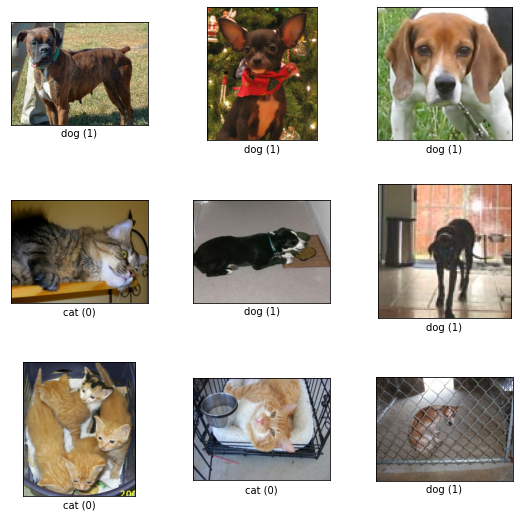

In [115]:
fig = tfds.show_examples(ds_train, ds_info)

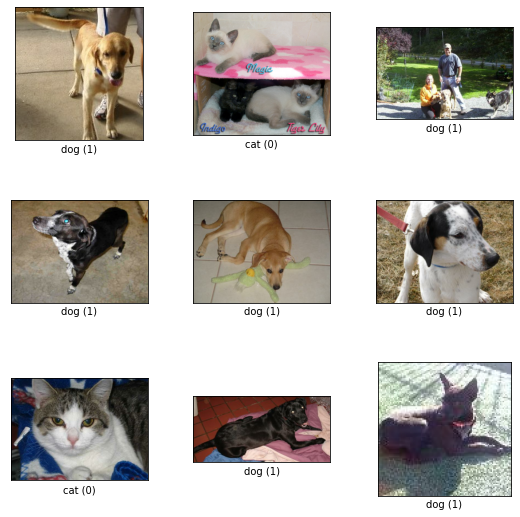

In [116]:
fig = tfds.show_examples(ds_test, ds_info)

In [105]:
def get_num_class(dataset):
    # 클래스별 카운트를 저장할 딕셔너리 초기화
    class_counts = {0: 0, 1: 0}

    # 데이터셋 순회하며 레이블 카운트
    for image, label in dataset:
        class_counts[label.numpy()] += 1
    
    return class_counts

- 학습용 데이터 기준, 고양이 9378, 개 9232

In [106]:
get_num_class(ds_train)

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


{0: 9378, 1: 9232}

- 검증용 데이터 기준, 고양이 2280, 개 2372

In [107]:
get_num_class(ds_test)

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


{0: 2280, 1: 2372}

- 이미지 사이즈가 다르니 같은 사이즈로 맞춰줄 필요가 있음.

In [117]:
cnt = 0

for img, label in ds_test:
    print(img.shape)
    cnt += 1
    if cnt == 3:
        break

(176, 168, 3)
(360, 400, 3)
(336, 500, 3)


- 데이터 전처리 함수 (Resize, Normalization)

In [118]:
def normalize_and_resize_img(image, label, size=(224, 224)):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, size)
    return tf.cast(image, tf.float32) / 255., label
    
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [119]:
BATCH_SIZE = 256
EPOCH = 15

In [120]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

### 학습

- 데이터셋에 맞게 모델 빌드

In [122]:
resnet_34 = build_resnet(input_shape=(224,224,3), num_classes=2, is_50=False)

In [123]:
resnet_34.compile(loss='sparse_categorical_crossentropy',
                  optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
                  metrics=['accuracy'])

history_34 = resnet_34.fit(ds_train,
                           epochs=EPOCH, validation_data=ds_test,verbose=1,
                           use_multiprocessing=True)

Epoch 1/15


KeyboardInterrupt: 

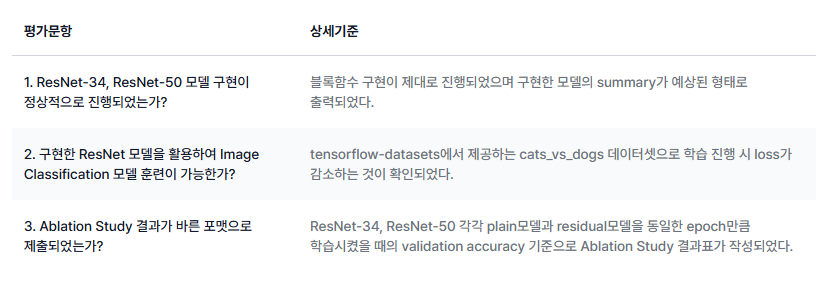